# Extended DMD with control for chaotic duffing oscillator

**Forced duffing oscillator**: 
This is example adapted from Nathan Kutz's course https://faculty.washington.edu/kutz/am568/am568.html), with dynamics given by:

$$\dot{x}_{1} = x_2,\\
\dot{x}_2 = -\delta x_2 - \alpha x_1 -\beta x_1^3 + u$$
with damped case $d=0.02,\alpha=-1, \beta=1$

In [1]:
import sys
sys.path.append('../src')

In [2]:
%matplotlib inline
import pykoopman as pk
from pykoopman.common.examples import forced_duffing, rk4, sine_wave  # required for example system
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility

import warnings
warnings.filterwarnings('ignore')

Training data: a training dataset is created consisting of 200 trajectories, each trajectory is integrated for 1000 timesteps and forced by a random actuation in the range $[-1,1]$. Each trajectory starts at a random initial condition in the unit box $[-1,1]^2$.

In [3]:
n_states = 2 # Number of states
n_inputs = 1 # Number of control inputs
dT = 0.01    # Timestep
n_traj = 200  # Number of trajectories
n_int = 1000  # Integration length

d = 0.02   # chaotic case

In [4]:
# Time vector
t = np.arange(0, n_int*dT, dT)

# Uniform random distributed forcing in [-1, 1]
u = 2*rnd.random([n_int, n_traj])-1

# Uniform distribution of initial conditions
x = 2*rnd.random([n_states, n_traj])-1

# Init
U = np.zeros((n_inputs, n_int*n_traj))
U = u.reshape(1,-1)
# Integrate to get data
model_fd = forced_duffing(dt=t[1]-t[0], d=d, alpha=-1, beta=1)
X,Y = model_fd.collect_data_discrete(x, n_int, u)

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$t$')]

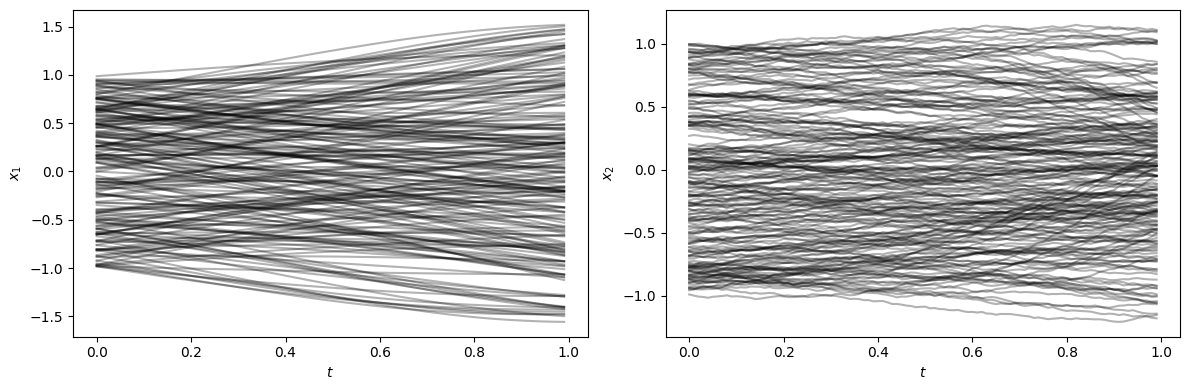

In [5]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    x = X[:, traj_idx::n_traj]
    axs[0].plot(t[0:100], x[0, 0:100], 'k',alpha=0.3)
    axs[1].plot(t[0:100], x[1, 0:100], 'k',alpha=0.3)
axs[0].set(ylabel=r'$x_1$', xlabel=r'$t$')
axs[1].set(ylabel=r'$x_2$', xlabel=r'$t$')

EDMDc model: The observables (or lifting functions) for the Koopman model are chosen to be the state itself ($\psi_1 = x_1,\psi_2=x_2$) (by setting `include_states=True` below, which is also the default) and thin plate radial basis functions with centers selected randomly.

In [6]:
EDMDc = pk.regression.EDMDc()

centers = np.random.uniform(-1.5,1.5,(2,4))
RBF = pk.observables.RadialBasisFunction(
    rbf_type="thinplate",
    n_centers=centers.shape[1],
    centers=centers,
    kernel_width=1,
    polyharmonic_coeff=1.0,
    include_state=True,
)

model = pk.Koopman(observables=RBF, regressor=EDMDc)
model.fit(X.T, y=Y.T, u=U.T)

Koopman(observables=RadialBasisFunction(centers=array([[-0.95376625,  0.11500887, -1.3650419 , -0.60594909],
       [-1.17360593,  0.36518006,  1.3439246 , -1.36668175]]),
                                        kernel_width=1, n_centers=4,
                                        rbf_type='thinplate'),
        regressor=EDMDc())

Compare prediction accuracy of Koopman model on a test trajectory

In the following, the trained model is used to perform a multi-step prediction from a given initial condition. The prediction is compared with the true trajectory when integrating the nonlinear system. Moreover, we will use a sine wave as input signal, which mimics the classic chaotic forced duffing oscillator (where cos wave is used.)

In [7]:
n_int = 3000  # Integration length
t = np.arange(0, n_int*dT, dT)
u = np.array([-sine_wave(step+1) for step in range(n_int)])
x = np.array([0.5, -0.5])
# x = np.array([[-0.1], [-0.5]])

# Integrate nonlinear system


Xtrue = np.zeros((n_states, n_int))
Xtrue[:, 0] = x
Xtrue = model_fd.simulate(Xtrue[:,0:1], n_int, u[:,np.newaxis])

Predict using Koopman model

In [8]:
# Multi-step prediction with Koopman/EDMDc model
Xkoop = model.simulate(x, u[:, np.newaxis], n_steps=n_int-1)
Xkoop = np.vstack([x[np.newaxis,:], Xkoop]) # add initial condition to simulated data for comparison below

Plot the results

(-2.5, 2.5)

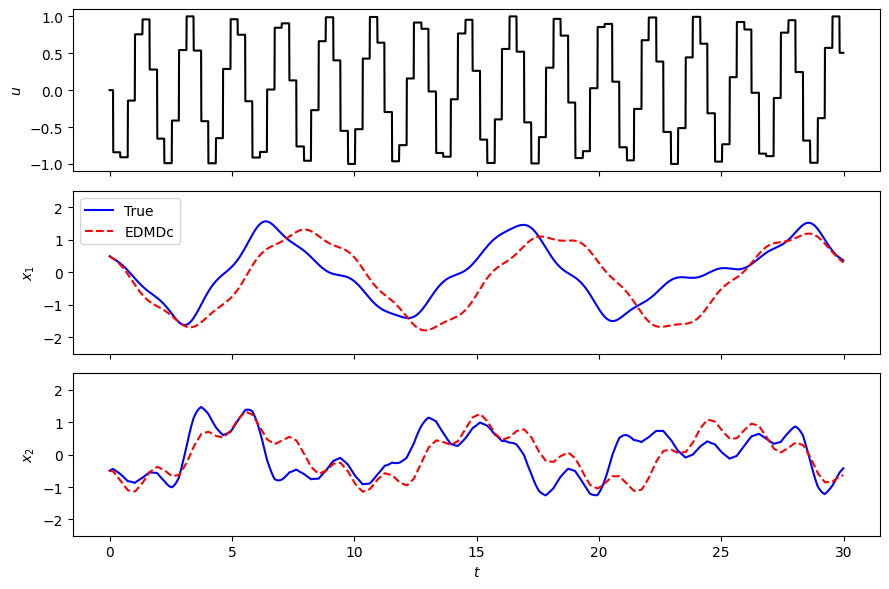

In [14]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[0].plot(t, u, '-k')
axs[0].set(ylabel=r'$u$')
axs[1].plot(t, Xtrue[0, :], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue[1, :], '-', color='b', label='True')
axs[2].plot(t, Xkoop[:, 1], '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')
axs[1].legend(loc='best')
axs[1].set_ylim([-2.5,2.5])
axs[2].set_ylim([-2.5,2.5])

Conclusion: 1) the Koopman model is only short time accurate, which makes sense. 2) the Koopman model exhibits simple periodic predictions in the long run

In [10]:
model.A.shape

(6, 6)

In [11]:
model.B.shape

(6, 1)

In [12]:
model.C.shape

(2, 6)

In [13]:
model.W.shape

(2, 6)